In [8]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
import cv2 as cv
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    SeparableConv2D,
    MaxPooling2D,
    Activation,
    Flatten,
    Dropout,
    Dense,
)
from tensorflow.keras.models import load_model

import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from os import listdir
import random

TensorFlow version: 2.8.0


In [9]:
DATASET_FOLDER = "dataset/digit smol"
HEIGHT = 28
WIDTH = 28
DEFAULT_IMAGE_SIZE = (28, 28)
INIT_LR = 1e-3
EPOCHS = 15
BATCH_SIZE = 32

def convert_image_to_array(image_src):
    try:
        image = cv.imread(image_src, cv.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv.resize(image, DEFAULT_IMAGE_SIZE)
            # imageMasked = mask_image(image)
            imgToArray = img_to_array(image) / 255.0
            # print(imgToArray)
            return imgToArray
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None


In [10]:
image_list = []
label_list = []
data = []
try:
    print("[INFO] Loading images ...")
    
    data_dir = listdir(f"{DATASET_FOLDER}")
    
    for eachDirectory in data_dir:
        print(f"[INFO] Processing {eachDirectory} ...")
        plant_disease_image_list = listdir(f"{DATASET_FOLDER}/{eachDirectory}/")
        # print(plant_disease_image_list)
        for image in plant_disease_image_list[50:]:
            image_directory = f"{DATASET_FOLDER}/{eachDirectory}/{image}"
            label = eachDirectory
            if image_directory.lower().endswith(".jpg") == True:
                # Converting each image into matrix
                arrayImage = convert_image_to_array(image_directory)
                # Adding the images, then labels to list
                image_list.append(arrayImage)
                label_list.append(label)
                # adding both image and label to data
                data.append([arrayImage, label])
    print("\n[INFO] Image loading completed")
    print("size", image_list[0].shape)
    
    print("\n[INFO] Total Images: ", len(data))
except Exception as e:
    print(f"Error : {e}")


# =================================================================================================
# Shuffle the data to remove bias towards any single sub-dataset
random.shuffle(data)
# print("\ndata[name]",data[1234][1])
# plt.imshow(data[1234][0])

X = []
Y = []
print(np.shape(data))
for features, labels in data:
    X.append(features)  # X is images
    Y.append(labels)  # Y is labels
images_count = len(X)

X = np.array(X)
Y = np.array(Y)

[INFO] Loading images ...
[INFO] Processing 0 ...
[INFO] Processing 1 ...
[INFO] Processing 2 ...
[INFO] Processing 3 ...
[INFO] Processing 4 ...
[INFO] Processing 5 ...
[INFO] Processing 6 ...
[INFO] Processing 7 ...
[INFO] Processing 8 ...
[INFO] Processing 9 ...

[INFO] Image loading completed
size (28, 28, 1)

[INFO] Total Images:  9520
(9520, 2)


C:\Users\Gourab Paul\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [11]:
image_list = X
label_list = Y
print(np.shape(image_list))
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)
print(n_classes)

(9520, 28, 28, 1)
10


In [12]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0


# ====================================================================================================
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(
    image_list, image_labels, test_size=0.3, random_state=42, shuffle=True
)


# ====================================================================================================
# aug = ImageDataGenerator(
#     rotation_range=25,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode="nearest",
# )

[INFO] Spliting data to train, test


In [13]:
# ====================================================================================================
model = Sequential()
# inputShape = (height, width, depth)
inputShape = (HEIGHT, WIDTH, 1)
chanDim = -1
if backend.image_data_format() == "channels_first":
    # inputShape = (depth, height, width)
    inputShape = (1, HEIGHT, WIDTH)
    chanDim = 1
model.add(Conv2D(32, kernel_size=(3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, kernel_size=(3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# model.add(Conv2D(128, kernel_size=(3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))

# model.add(Conv2D(128, kernel_size=(3, 3), padding="same"))
# model.add(Activation("relu"))
# model.add(BatchNormalization(axis=chanDim))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))


# ====================================================================================================
model.summary()
# ====================================================================================================
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
# loss = keras.losses.categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# train the network
print("[INFO] training network...")


# ====================================================================================================
history = model.fit(
    # aug.flow(x_train, y_train, batch_size=BATCH_SIZE),
    x = x_train,
    y = y_train,
    validation_split = 0.2,
    # validation_data=(x_test, y_test),
    # steps per epoch? not a fixed number like 16 or 32?
    # steps_per_epoch=len(x_train) // BATCH_SIZE,
    epochs=20,
    verbose=1,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 activation_4 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 32)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 9, 9, 32)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 64)         

In [14]:
# Save the model

# pickle.dump(model, open("digits_model.pkl", "wb"))
model.save("my_model")
model.save('my_model.h5')

INFO:tensorflow:Assets written to: my_model\assets


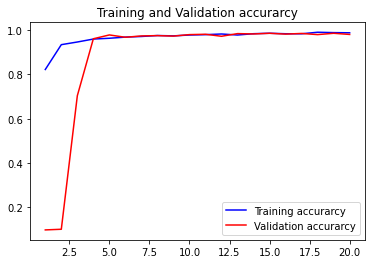

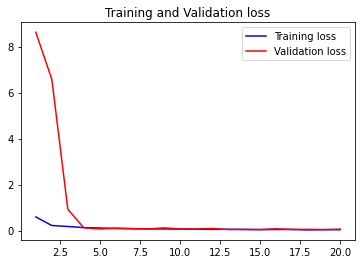

In [15]:
# PLOT THE MODEL

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
# Train and validation accuracy
plt.plot(epochs, acc, "b", label="Training accurarcy")
plt.plot(epochs, val_acc, "r", label="Validation accurarcy")
plt.title("Training and Validation accurarcy")
plt.legend()

plt.figure()
# Train and validation loss
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

In [18]:
# pickled_model = pickle.load(open('digits_model.pkl', 'rb'))
# loaded_model = pickled_model

pickled_model = tf.keras.models.load_model('my_model.h5')
loaded_model = pickled_model

# loaded_model = model


def predict(src):
    path = src
    img = load_img(path, target_size=(28,28))
    img_matrix = convert_image_to_array(path)
    toBePredictedImage = np.expand_dims(img_matrix, axis=0)
    
    result = loaded_model.predict(toBePredictedImage)
    predictedClass = [np.argmax(element) for element in result]
    image_folder = path[19:20]
    boolResult = False
    if str(image_folder) == str(predictedClass[0]):
        boolResult = True
    # print(f"\n{path} --- Predicted Class {predictedClass} --- Result {result} --- Correct?? {boolResult}")
    return boolResult

test_set = []
correct_results = 0
wrong_results = 0
for eachDirectory in listdir(f"{DATASET_FOLDER}"):
    plant_disease_image_list = listdir(f"{DATASET_FOLDER}/{eachDirectory}/")
    for image in plant_disease_image_list[1:49]:
        test_set.append(f"{DATASET_FOLDER}/{eachDirectory}/{image}")
random.shuffle(test_set)
for image in test_set:
    result = predict(image)
    if(result==True):
        correct_results += 1
    else:
        wrong_results += 1
print("correct_results ---> ",correct_results,"    wrong_results ---> ",wrong_results)

correct_results --->  467     wrong_results --->  13
